#Install & Import Libraries


In [ ]:
!pip3 install pydub
!pip3 install xmltodict
!pip3 install resemblyzer
!pip3 install pyannote.core
!pip3 install noisereduce
!pip3 install pyannote.metrics
!pip3 install python_speech_features
!pip3 install spectralcluster
!pip3 install hdbscan
!pip3 install keras
!pip3 install tensorflow_addons

     |████████████████████████████████| 15.7MB 169kB/s 
     |████████████████████████████████| 71kB 10.1MB/s 
     |████████████████████████████████| 81kB 10.9MB/s 
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp37-cp37m-linux_x86_64.whl size=72324 sha256=9151714c2812845237d76fa60bd83b57cb6bda050742d95e27faa19113d891f4
  Stored in directory: /root/.cache/pip/wheels/44/2a/18/bd1aec41cac7c3051fe95d92a6ed446122ea31dc713c432fa1
  Created wheel for typing: filename=typing-3.7.4.3-cp37-none-any.whl size=26308 sha256=1d8ce818314c1364608f72d831d15d78581b54aa209e4799af910565c0434afc
  Stored in directory: /root/.cache/pip/wheels/2d/04/41/8e1836e79581989c22eebac3f4e70aaac9af07b0908da173be
Successfully built webrtcvad typing


     |████████████████████████████████| 61kB 5.1MB/s 
     |████████████████████████████████| 133kB 14.0MB/s 
  Created wheel for noisereduce: filename=noisereduce-1.1.0-cp37-none-any.whl size=7610 sha256=c20b11cf7e8acae34b3ade2a48e34812a602f076e89daef2f9229efe6f5f496f
  Stored in directory: /root/.cache/pip/wheels/a6/2c/70/f9ccb41280dcfbe3eaeb7930f913dd85394617f3d3136f29cc
Successfully built noisereduce
     |████████████████████████████████| 51kB 4.5MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 92kB 8.0MB/s 
  Found existing installation: click 8.0.0
    Uninstalling click-8.0.0:
      Successfully uninstalled click-8.0.0
  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp37-none-any.whl size=5887 sha256=9ba9857ad78187ee10b17ec4a767088d52f345d53aeee8cfc0ee563688f5881e
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-s

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title
# For importing code from drive
import sys
sys.path.append('/content/drive/MyDrive/ATML/code')

import VAD
from VAD import fxn, speech

# preprocess using mfcc
import preprocess
from preprocess import *

import model
from model import *

In [ ]:
#@title
from pydub import AudioSegment
import xmltodict
import os
os.path.join('a','b')

from resemblyzer import VoiceEncoder, preprocess_wav
from pathlib import Path
import numpy as np

from operator import itemgetter
from lxml import etree
import xml.etree.ElementTree as ET
import json

import librosa
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio, display
from math import ceil

from pyannote.core import Segment, Timeline, Annotation, notebook
import noisereduce as nr
from tqdm import tqdm

from python_speech_features import fbank
from random import choice

import numpy as np

#Data Preprocessing



In [ ]:
#@title
# Constants.

SAMPLE_RATE = 16000  # not higher than that otherwise we may have errors when computing the fbanks.

BATCH_SIZE = 32 * 3  # have to be a multiple of 3.

NUM_FRAMES = 44  
NUM_FBANKS = 20

In [ ]:
###################### PATH TO CORPUS & AUDIO FOLDER ######################
AMI_CORPUS_FOLDER = './drive/MyDrive/ATML/ami_public_manual_1.6.2/words'
# AMI_CORPUS_FOLDER2 = './drive/MyDrive/amicorpusfinal/ami_public_manual_1.6.2/words'
# AMI_AUDIO_FOLDER = './drive/MyDrive/ATML/amicorpus/'
# AMI_AUDIO_FOLDER1 = './drive/MyDrive/amicorpus/'
AMI_AUDIO_FOLDER2 = './drive/MyDrive/amicorpusfinal/'
 
SPEAKERS = ['A', 'B', 'C', 'D']
X_FILENAME = 'X_withoutEmbedding_LSTM.txt'
Y_FILENAME = 'y_LSTM.txt'
TIME_FILENAME = 'startEndTime_LSTM.txt'

THRESHOLD_VAD = 0



In [ ]:
#@title
import pickle

def write(list1,filename):
  l = list1
  with open(filename, "wb") as fp:   #Pickling
    pickle.dump(l, fp)

def read(filename):
  with open(filename, "rb") as fp:   # Unpickling
    b = pickle.load(fp)
  return b



###Read Training Data


In [ ]:
#@title
# # code to store X_withoutEmbedding startEndTime y in txt file
# # Put file names in WORKING_RECORDING_IDS list to create text file


# def read_xml_and_split(RECORDING_ID,AMI_AUDIO_FOLDER):
#   X_withoutEmbedding = []
#   y = []
#   startEndTime = []


#   y_ref = []
#   startEndTime_ref = []

#   speakers_phrases = []
#   for index, speaker in enumerate(SPEAKERS):
#       t = parse_ami_transcript_xml(
#           f"{AMI_CORPUS_FOLDER}/{RECORDING_ID}.{speaker}.words.xml", index)
#       speakers_phrases.extend(t)
#   final = sorted(speakers_phrases, key=itemgetter('start'))
#   print(len(final))

#   for i in range(len(final)):
#     speaker = final[i]['speaker_id']
#     startEndTime_ref.append([final[i]['start'],final[i]['end']])
#     y_ref.append(speaker)

#   for i in range(len(final)-1):
#     if(final[i]['end']>final[i+1]['start']):
#       final[i]['end']=final[i+1]['start']


#   # print(final)
#   inverseWindowLength = 1 
#   for i in range(len(final)):
#     speaker = final[i]['speaker_id']
#     # print(speaker)
#     # print(int(inverseWindowLength*(final[i]['end']-final[i]['start'])))
#     for j in range(0,int(inverseWindowLength*(final[i]['end']-final[i]['start']))):
#       # print(j)

#       split_wav(os.path.join(AMI_AUDIO_FOLDER,RECORDING_ID,'audio'),f'{RECORDING_ID}.Mix-Headset.wav',final[i]['start']+j/inverseWindowLength,final[i]['start']+(j+1)/inverseWindowLength,f'{speaker}_{i}_{j}')
      
#       frame_size = 2048
#       frame_shift = 512

#       y, sr = librosa.load(os.path.join(AMI_AUDIO_FOLDER,RECORDING_ID,'audio',f'{RECORDING_ID}.Mix-Headset_{speaker}_{i}_{j}.wav'))
#       mfccs = librosa.feature.mfcc(y, sr, n_mfcc=20)
#       mfcc_delta = librosa.feature.delta(mfccs)
#       mfcc_delta2 = librosa.feature.delta(mfccs, order=2)

#       print(mfccs.shape)

#       mfcc = mfccs[1:, ]
#       norm_mfcc = (mfcc - np.mean(mfcc, axis=1, keepdims=True)) / np.std(mfcc, axis=1, keepdims=True)
#       norm_mfcc_delta = (mfcc_delta - np.mean(mfcc_delta, axis=1, keepdims=True)) / np.std(mfcc_delta, axis=1, keepdims=True)
#       norm_mfcc_delta2 = (mfcc_delta2 - np.mean(mfcc_delta2, axis=1, keepdims=True)) / np.std(mfcc_delta2, axis=1, keepdims=True)

#       ac_feature = np.vstack((norm_mfcc, norm_mfcc_delta, norm_mfcc_delta2))

#       X_withoutEmbedding.append(ac_feature)

#       predict_x, feature_len = extract_feature()
#       print(predict_x.shape)


      
#       # wav = sample_from_mfcc(read_mfcc(os.path.join(AMI_AUDIO_FOLDER,RECORDING_ID,'audio',f'{RECORDING_ID}.Mix-Headset_{speaker}_{i}_{j}.wav'), SAMPLE_RATE), NUM_FRAMES)
#       # X_withoutEmbedding.append(wav)
#       # # X.append(embed)
#       # y.append(speaker)
#       # startEndTime.append([final[i]['start']+j/inverseWindowLength,final[i]['start']+(j+1)/inverseWindowLength])
    
#   # write(X_withoutEmbedding,os.path.join(AMI_AUDIO_FOLDER,RECORDING_ID,X_FILENAME))
#   # write(startEndTime,os.path.join(AMI_AUDIO_FOLDER,RECORDING_ID,TIME_FILENAME))
#   # write(y,os.path.join(AMI_AUDIO_FOLDER,RECORDING_ID,Y_FILENAME))


# IS = ['IS1000b', 'IS1001b', 'IS1002b', 'IS1003b', 'IS1004b', 'IS1005b', 'IS1006b', 'IS1007b', 'IS1008b', 'IS1009b']
# TS = ['TS3003b', 'TS3004b', 'TS3005b', 'TS3006b', 'TS3007b', 'TS3008b', 'TS3009b', 'TS3010b', 'TS3011b', 'TS3012b']
# ES = ['ES2002a', 'ES2004a', 'ES2005a', 'ES2006a', 'ES2006b', 'ES2007a', 'ES2009a', 'ES2010a', 'ES2011a', 'ES2012a']

# # WORKING_RECORDING_IDS = []
# # for id in WORKING_RECORDING_IDS:
#   # read_xml_and_split(id,AMI_AUDIO_FOLDER2)

# read_xml_and_split('ES2002a',AMI_AUDIO_FOLDER2)

In [ ]:
#@title
# # code to store X_withoutEmbedding startEndTime y in txt file
# # Put file names in WORKING_RECORDING_IDS list to create text file


# def read_xml_and_split(RECORDING_ID,AMI_AUDIO_FOLDER):
#   X_withoutEmbedding = []
#   y = []
#   startEndTime = []


#   y_ref = []
#   startEndTime_ref = []

#   speakers_phrases = []
#   for index, speaker in enumerate(SPEAKERS):
#       t = parse_ami_transcript_xml(
#           f"{AMI_CORPUS_FOLDER}/{RECORDING_ID}.{speaker}.words.xml", index)
#       speakers_phrases.extend(t)
#   final = sorted(speakers_phrases, key=itemgetter('start'))
#   print(len(final))

#   for i in range(len(final)):
#     speaker = final[i]['speaker_id']
#     startEndTime_ref.append([final[i]['start'],final[i]['end']])
#     y_ref.append(speaker)

#   for i in range(len(final)-1):
#     if(final[i]['end']>final[i+1]['start']):
#       final[i]['end']=final[i+1]['start']

#   inverseWindowLength = 1 
#   for i in range(len(final)):
#     speaker = final[i]['speaker_id']
#     for j in range(0,int(inverseWindowLength*(final[i]['end']-final[i]['start']))):
#       # split_wav(os.path.join(AMI_AUDIO_FOLDER,RECORDING_ID,'audio'),f'{RECORDING_ID}.Mix-Headset.wav',final[i]['start']+j/inverseWindowLength,final[i]['start']+(j+1)/inverseWindowLength,f'{speaker}{i}{j}')

      
#       frame_size = 2048
#       frame_shift = 512


#       # if os.path.join(AMI_AUDIO_FOLDER,RECORDING_ID,'audio',f'{RECORDING_ID}.Mix-Headset_{speaker}_{i}_{j}.wav') == './drive/MyDrive/amicorpusfinal/ES2002a/audio/ES2002a.Mix-Headset_1_61_0.wav':
#       #     continue


#       if i==61 and j==0 and RECORDING_ID == 'ES2002a':
#           continue

#       temp, sr = librosa.load(os.path.join(AMI_AUDIO_FOLDER,RECORDING_ID,'audio',f'{RECORDING_ID}.Mix-Headset_{speaker}_{i}_{j}.wav'))
#       mfccs = librosa.feature.mfcc(temp, sr, n_mfcc=20, hop_length=frame_shift, n_fft=frame_size)
#       mfcc_delta = librosa.feature.delta(mfccs)
#       mfcc_delta2 = librosa.feature.delta(mfccs, order=2)

#       # print(mfccs.shape)

#       mfcc = mfccs[1:, ]
#       norm_mfcc = (mfcc - np.mean(mfcc, axis=1, keepdims=True)) / np.std(mfcc, axis=1, keepdims=True)
#       norm_mfcc_delta = (mfcc_delta - np.mean(mfcc_delta, axis=1, keepdims=True)) / np.std(mfcc_delta, axis=1, keepdims=True)
#       norm_mfcc_delta2 = (mfcc_delta2 - np.mean(mfcc_delta2, axis=1, keepdims=True)) / np.std(mfcc_delta2, axis=1, keepdims=True)

#       ac_feature = np.vstack((norm_mfcc, norm_mfcc_delta, norm_mfcc_delta2))




#       X_withoutEmbedding.append(ac_feature)
#       y.append(speaker)
#       startEndTime.append([final[i]['start']+j/inverseWindowLength,final[i]['start']+(j+1)/inverseWindowLength])
#   return X_withoutEmbedding, y, startEndTime
#   # write(X_withoutEmbedding,os.path.join(AMI_AUDIO_FOLDER,RECORDING_ID,X_FILENAME))
#   # write(startEndTime,os.path.join(AMI_AUDIO_FOLDER,RECORDING_ID,TIME_FILENAME))
#   # write(y,os.path.join(AMI_AUDIO_FOLDER,RECORDING_ID,Y_FILENAME))


# IS = ['IS1000b', 'IS1001b', 'IS1002b', 'IS1003b', 'IS1004b', 'IS1005b', 'IS1006b', 'IS1007b', 'IS1008b', 'IS1009b']
# TS = ['TS3003b', 'TS3004b', 'TS3005b', 'TS3006b', 'TS3007b', 'TS3008b', 'TS3009b', 'TS3010b', 'TS3011b', 'TS3012b']
# ES = ['ES2002a', 'ES2004a', 'ES2005a', 'ES2006a', 'ES2006b', 'ES2007a', 'ES2009a', 'ES2010a', 'ES2011a', 'ES2012a']


# WORKING_RECORDING_IDS = ['ES2002a', 'ES2004a', 'ES2005a', 'ES2006a']

# TEST_WORKING_RECORDING_IDS = ['ES2011a']


# def modifyTime(startEndTime):
#   temp = [0]
#   for i in range(1,len(startEndTime)):
#     if(startEndTime[i][0]<startEndTime[i-1][0]):
#       temp.append(temp[i-1]+startEndTime[i-1][1])
#     else:
#       temp.append(temp[i-1]) 
#   for i in range(len(startEndTime)):
#     startEndTime[i][0] = startEndTime[i][0] + temp[i] 
#     startEndTime[i][1] = startEndTime[i][1] + temp[i]
#   return temp



# X_LSTM, y_LSTM, startEndTime_LSTM = read_xml_and_split(WORKING_RECORDING_IDS[0],AMI_AUDIO_FOLDER2)
# for i in range(1, len(WORKING_RECORDING_IDS)):
#   X_withoutEmbedding_temp, y_temp, startEndTime_temp = read_xml_and_split(WORKING_RECORDING_IDS[i],AMI_AUDIO_FOLDER2)
#   ## modify y
#   y_temp = [n + 4*i for n in y_temp]
#   ## modify startEndTime
#   startEndTime_LSTM.extend(startEndTime_temp)
#   modifyTime(startEndTime_LSTM)
#   X_LSTM.extend(X_withoutEmbedding_temp)
#   y_LSTM.extend(y_temp)


# X_LSTM_test, y_LSTM_test, startEndTime_LSTM_test = read_xml_and_split(TEST_WORKING_RECORDING_IDS[0],AMI_AUDIO_FOLDER2)
# for i in range(1, len(TEST_WORKING_RECORDING_IDS)):
#   X_withoutEmbedding_temp, y_temp, startEndTime_temp = read_xml_and_split(TEST_WORKING_RECORDING_IDS[i],AMI_AUDIO_FOLDER2)
#   ## modify y
#   y_temp = [n + 4*i for n in y_temp]
#   ## modify startEndTime
#   startEndTime_LSTM_test.extend(startEndTime_temp)
#   modifyTime(startEndTime_LSTM_test)
#   X_LSTM_test.extend(X_withoutEmbedding_temp)
#   y_LSTM_test.extend(y_temp)




In [ ]:
# Code to read X_withoutEmbedding startEndTime y from txt file
# Put file names in WORKING_RECORDING_IDS list to get X_withoutEmbedding startEndTime y 

# WORKING_RECORDING_IDS = ['ES2002a','ES2004a','ES2005a','ES2006a','ES2007a','ES2009a','ES2010a','ES2011a','ES2012a','ES2006b','ES2007b','ES2009b','ES2010b','ES2011b','ES2012b']

TRAIN_WORKING_RECORDING_IDS = ['IS1000b', 'IS1001b', 'IS1002b', 'IS1003b', 'IS1004b', 'IS1005b', 'IS1006b', 
                               'TS3003b', 'TS3004b', 'TS3005b', 'TS3006b', 'TS3007b', 'TS3008b', 'TS3009b',
                               'ES2002a', 'ES2004a', 'ES2005a', 'ES2006a', 'ES2006b', 'ES2007a', 'ES2009a']



VAL_WORKING_RECORDING_IDS = ['IS1007b', 'IS1008b',
                             'TS3010b', 'TS3011b',
                             'ES2010a', 'ES2011a']

TEST_WORKING_RECORDING_IDS = [ 'IS1009b',
                              'TS3012b',
                              'ES2012a']

# For Reading stored Data
def read_all(RECORDING_ID,AMI_AUDIO_FOLDER):
  X_withoutEmbedding = read(os.path.join(AMI_AUDIO_FOLDER,RECORDING_ID,X_FILENAME))
  y = read(os.path.join(AMI_AUDIO_FOLDER,RECORDING_ID,Y_FILENAME))
  startEndTime = read(os.path.join(AMI_AUDIO_FOLDER,RECORDING_ID,TIME_FILENAME))
  return X_withoutEmbedding, y, startEndTime

# For modifying time so that time will not overlap of different file 
def modifyTime(startEndTime):
  temp = [0]
  for i in range(1,len(startEndTime)):
    if(startEndTime[i][0]<startEndTime[i-1][0]):
      temp.append(temp[i-1]+startEndTime[i-1][1])
    else:
      temp.append(temp[i-1]) 
  for i in range(len(startEndTime)):
    startEndTime[i][0] = startEndTime[i][0] + temp[i] 
    startEndTime[i][1] = startEndTime[i][1] + temp[i]
  return temp

# Appending all the x,y vectors to create single x,y vector list
def createFinalList(WORKING_RECORDING_IDS,AMI_AUDIO_FOLDER):
  X_withoutEmbedding, y, startEndTime = read_all(WORKING_RECORDING_IDS[0],AMI_AUDIO_FOLDER)
  for i in range(1,len(WORKING_RECORDING_IDS)):
    X_withoutEmbedding_temp, y_temp, startEndTime_temp = read_all(WORKING_RECORDING_IDS[i],AMI_AUDIO_FOLDER)
    ## modify y
    y_temp = [n + 4*i for n in y_temp]
    ## modify startEndTime
    startEndTime.extend(startEndTime_temp)
    modifyTime(startEndTime)
    X_withoutEmbedding.extend(X_withoutEmbedding_temp)
    y.extend(y_temp)
    
  return X_withoutEmbedding, y, startEndTime


## For DER Calculation
X_withoutEmbedding, y, startEndTime = read_all(TRAIN_WORKING_RECORDING_IDS[0],AMI_AUDIO_FOLDER2)
X_withoutEmbedding_test, y_test, startEndTime_test = read_all(TEST_WORKING_RECORDING_IDS[0],AMI_AUDIO_FOLDER2)

In [ ]:
## Read Dataset from Already Preprocessed Dataset

WORKING_RECORDING_IDS = ['IS1000b', 'IS1001b', 'IS1002b', 'IS1003b', 'IS1004b', 'IS1005b', 'IS1006b', 
                               'TS3003b', 'TS3004b', 'TS3005b', 'TS3006b', 'TS3007b', 'TS3008b', 'TS3009b',
                               'ES2002a', 'ES2004a', 'ES2005a', 'ES2006a', 'ES2006b', 'ES2007a', 'ES2009a',
                              'IS1007b', 'IS1008b',
                             'TS3010b', 'TS3011b',
                             'ES2010a', 'ES2011a']
X, y, _ = createFinalList(WORKING_RECORDING_IDS,AMI_AUDIO_FOLDER2)


### Create Tenserflow Dataset from Preprocessed Chunks + Labels



In [ ]:
from sklearn.model_selection import train_test_split

X_LSTM, X_LSTM_test, y_LSTM, y_LSTM_test = train_test_split(X, y, test_size = 0.2, shuffle = True)

In [ ]:
X_LSTM = np.resize(X_LSTM, (len(X_LSTM), 74, 35))
X_LSTM_test = np.resize(X_LSTM_test, (len(X_LSTM_test), 74, 35))
print(X_LSTM.shape)  

(19776, 74, 35)


In [ ]:
print(len(y_LSTM))
print(np.unique(y_LSTM))

19776
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107]


In [ ]:
print(len(y_LSTM_test))
print(np.unique(y_LSTM_test))

4945
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 106 107]


In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import keras.layers as layers


In [ ]:
# Modifing vector according to LSTM Model requirement

def map_data(data, label):
    return (data, label)


train_dataset = tf.data.Dataset.from_tensor_slices((X_LSTM, y_LSTM)) 
train_dataset = train_dataset.batch(32)
train_dataset = train_dataset.map(map_data)

## Uncomment this if using validation 

test_dataset = tf.data.Dataset.from_tensor_slices((X_LSTM_test, y_LSTM_test)) 
test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.map(map_data)

# Create Embeddings using LSTM Model

###Define Hindi-English-BiLSTM Architecture and Triplet Net Model


In [ ]:
from keras.layers.core import Dense
from keras.layers import LSTM, Bidirectional, TimeDistributed, Dropout

## Hindi-English-LSTM Network for Encoding Speech MFCC Features into Embedding vector

model = keras.Sequential()

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(TimeDistributed(Dense(32)))
model.add(TimeDistributed(Dense(32)))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))

model.build(input_shape = (None, 74, 35)) 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 74, 256)           167936    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 74, 256)           394240    
_________________________________________________________________
time_distributed (TimeDistri (None, 74, 32)            8224      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 74, 32)            1056      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 74, 1)             33        
Total params: 571,489
Trainable params: 571,489
Non-trainable params: 0
_________________________________________________________________



### Load Hindi-English-BiLSTM Model Weights


In [ ]:
h5_model_file = '/content/drive/My Drive/Hindi/model_hindi_2.h5'
model.load_weights(h5_model_file)

### Generate "Refined Dataset" by running the Hindi-English BiLSTM Model on raw MFCC features


In [ ]:
## Generating output from pretrained model, which is used as training data to added layers

vad_train_output = model.predict(train_dataset)
vad_test_output = model.predict(test_dataset)

vad_train_output = vad_train_output.reshape(vad_train_output.shape[0], vad_train_output.shape[1])
vad_test_output = vad_test_output.reshape(vad_test_output.shape[0], vad_test_output.shape[1])



embedder_train_dataset = tf.data.Dataset.from_tensor_slices((vad_train_output, y_LSTM)) 
embedder_train_dataset = embedder_train_dataset.batch(32)
embedder_train_dataset = embedder_train_dataset.map(map_data)


embedder_test_dataset = tf.data.Dataset.from_tensor_slices((vad_test_output, y_LSTM_test)) 
embedder_test_dataset = embedder_test_dataset.batch(32)
embedder_test_dataset = embedder_test_dataset.map(map_data)

In [ ]:
print(vad_train_output.shape)

(19776, 74)


### Define AMI-LSTM Embedding Architecture


In [ ]:
## Dense Layer Network for Encoding Speech MFCC Features into Embedding vector

embedder = keras.Sequential()

embedder.add(layers.Dense(128,  input_shape = (74,), activation='tanh'))
embedder.add(layers.Dropout(0.01))
embedder.add(layers.Dense(128, activation=None))
embedder.add(layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)))

embedder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               9600      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
lambda (Lambda)              (None, 128)               0         
Total params: 26,112
Trainable params: 26,112
Non-trainable params: 0
_________________________________________________________________


###Define Model Training Function

In [ ]:
from keras.callbacks import ModelCheckpoint
## Use CallBack to keep track of best performing model till yet and save its weights
best_model_file = "/content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_1_Best.h5"
best_model = ModelCheckpoint(best_model_file, monitor='val_loss',
                             mode='min',
                             save_best_only=True,verbose=1)

In [ ]:
# Compiling Model
embedder.compile(optimizer=keras.optimizers.Adam(learning_rate=.1), loss=tfa.losses.TripletHardLoss())

'''
## fitting model
embedder_history = embedder.fit(embedder_train_dataset, epochs=50, validation_data=embedder_test_dataset, callbacks=[best_model])
'''

Epoch 1/50
618/618 [==============================] - 2s 2ms/step - loss: 0.6702 - val_loss: 0.4606

Epoch 00001: val_loss improved from inf to 0.46057, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_1_Best.h5
Epoch 2/50
618/618 [==============================] - 1s 2ms/step - loss: 0.4490 - val_loss: 0.4359

Epoch 00002: val_loss improved from 0.46057 to 0.43593, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_1_Best.h5
Epoch 3/50
618/618 [==============================] - 1s 2ms/step - loss: 0.4256 - val_loss: 0.4310

Epoch 00003: val_loss improved from 0.43593 to 0.43102, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_1_Best.h5
Epoch 4/50
618/618 [==============================] - 1s 2ms/step - loss: 0.4155 - val_loss: 0.4164

Epoch 00004: val_loss improved from 0.43102 to 0.41639, saving model to /content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_1_Best

In [ ]:
## Loading Best embedder 
embedder.load_weights("/content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_1_Best.h5")

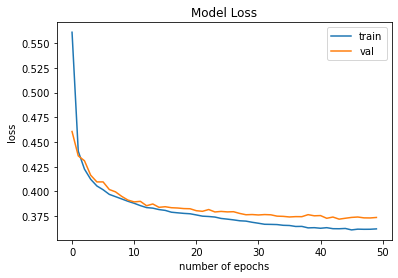

In [ ]:
# plt.plot(embedder_history.history['loss'])
# plt.plot(embedder_history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('loss')
# plt.xlabel('number of epochs')
# plt.legend((['train', 'val']), loc='upper right')
# plt.show()

In [ ]:
'''
## Uncomment this code to save the model weights obtained at training for all the epochs
model.save('/content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_1_50Epoch.h5')
'''

In [ ]:
'''
## Uncomment this code to save the model history obtained at the end of training
with open('/content/drive/MyDrive/TransferLearningBestModels/Transfer__Learning_1_50Epoch_history', 'wb') as file_pi:
        pickle.dump(embedder_history.history, file_pi)
'''

In [ ]:
## Creating X, y, start end time vector on train and test data for DER calculation

## Training data
X_withoutEmbedding, y, startEndTime = read_all(TRAIN_WORKING_RECORDING_IDS[20],AMI_AUDIO_FOLDER2)
X_withoutEmbedding = np.resize(X_withoutEmbedding, (len(X_withoutEmbedding), 74, 35))

## Unknown test data
X_withoutEmbedding_test, y_test, startEndTime_test = read_all(TEST_WORKING_RECORDING_IDS[2],AMI_AUDIO_FOLDER2)
X_withoutEmbedding_test = np.resize(X_withoutEmbedding_test, (len(X_withoutEmbedding_test), 74, 35))

In [ ]:
## Modifing train data according to LSTM Model requirement
train_dataset_embedding = tf.data.Dataset.from_tensor_slices((X_withoutEmbedding, y)) 
train_dataset_embedding = train_dataset_embedding.batch(32)
train_dataset_embedding = train_dataset_embedding.map(map_data)

## Modifing test data according to LSTM Model requirement
test_dataset_embedding = tf.data.Dataset.from_tensor_slices((X_withoutEmbedding_test, y_test)) 
test_dataset_embedding = test_dataset_embedding.batch(32)
test_dataset_embedding = test_dataset_embedding.map(map_data)

In [ ]:
# Creating embedding from trained LSTM Model on train and test data

train_embeddings_t0, train_labels_tl = model.predict(train_dataset_embedding), y
test_embeddings_t0, test_labels_tl = model.predict(test_dataset_embedding), y_test

train_embeddings_t0 = np.squeeze(train_embeddings_t0,-1)
test_embeddings_t0 = np.squeeze(test_embeddings_t0,-1)

In [ ]:
## Extract Embeddings

train_embeddings_tl, train_labels_tl = embedder.predict(train_embeddings_t0), y
test_embeddings_tl, test_labels_tl = embedder.predict(test_embeddings_t0), y_test


In [ ]:
X, y = np.array(train_embeddings_tl), np.array([int(i) for i in train_labels_tl])

In [ ]:
X_test, y_test =  np.array(test_embeddings_tl), np.array([int(i) for i in test_labels_tl])

# Cluster Plot of Embeddings

####PCA for Dataset Emebeddings (with True Labels)


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA

def preprocessingX(X):
  # Preprocessing the data to make it visualizable 
  raw_df = pd.DataFrame(X)  

  # Scaling the Data 
  scaler = StandardScaler() 
  X_scaled = scaler.fit_transform(raw_df) 

  # Normalizing the Data 
  X_normalized = preprocessing.normalize(X_scaled) 

  # Converting the numpy array into a pandas DataFrame 
  X_normalized = pd.DataFrame(X_normalized) 

  # Reducing the dimensions of the data 
  pca = PCA(n_components = 2) 
  X_principal = pca.fit_transform(X_normalized) 
  X_principal = pd.DataFrame(X_principal) 
  X_principal.columns = ['P1', 'P2'] 
  return X_principal

X_principal = preprocessingX(X)
X_principal_test = preprocessingX(X_test)

X_principal.head(2) 

,P1,P2
0,-0.064280,-0.224360
1,0.032527,0.140342


In [ ]:
print(X_LSTM_test.shape)

(4558, 59, 44)


###Plot of Spectral Clustering When exact number of speakers known

####Using Radial Basis Function 


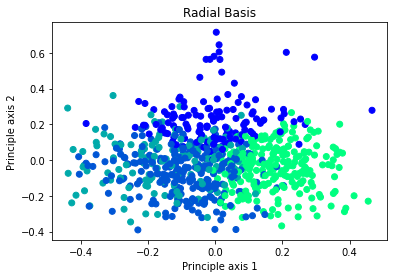

In [ ]:
from sklearn.cluster import SpectralClustering

# Building the clustering model 
spectral_model_rbf = SpectralClustering(n_clusters = 4, affinity ='rbf') 

# Training the model and Storing the predicted cluster labels 
labels_rbf = spectral_model_rbf.fit_predict(X_principal)

# Visualizing the clustering
plt.scatter(X_principal['P1'], X_principal['P2'],
           c = SpectralClustering(n_clusters = 4, affinity ='rbf') .fit_predict(X), cmap =plt.cm.winter) 
plt.title("Radial Basis")
plt.xlabel("Principle axis 1")
plt.ylabel("Principle axis 2")
plt.savefig('/content/drive/MyDrive/plots/Cluster4RBF.png')
plt.show() 

####Using Nearest Neighbours function

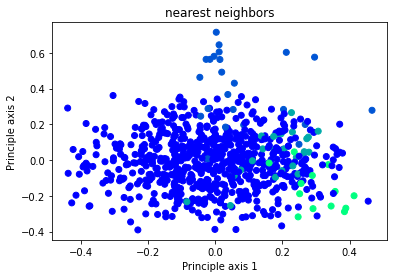

In [ ]:
# Building the clustering model 
spectral_model_nn = SpectralClustering(n_clusters = 4, affinity ='nearest_neighbors') 
  
# Training the model and Storing the predicted cluster labels 
labels_nn = spectral_model_nn.fit_predict(X_principal)

# Visualizing the clustering 
plt.scatter(X_principal['P1'], X_principal['P2'],  
           c = SpectralClustering(n_clusters = 4, affinity ='nearest_neighbors') .fit_predict(X), cmap =plt.cm.winter) 
plt.title("nearest neighbors")
plt.xlabel("Principle axis 1")
plt.ylabel("Principle axis 2")
plt.savefig('/content/drive/MyDrive/plots/Cluster3NN.png')
plt.show() 

###Plot of Spectral Clustering When number of speaker not known beforehand


### Scatter Plot with True Labels as color vector (4 clusters -> 4 speakers)

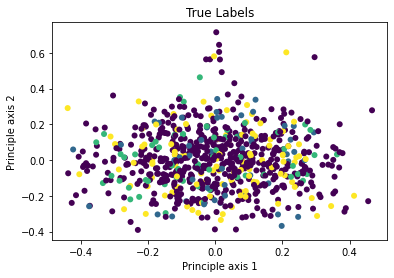

In [ ]:
c = np.random.choice(range(4), 100)

# plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
# plot x,y data with c as the color vector, set the line width of the markers to 0
ax.scatter(X_principal['P1'], X_principal['P2'], c=y, lw=0)
plt.title("True Labels")
plt.xlabel("Principle axis 1")
plt.ylabel("Principle axis 2")
plt.savefig('/content/drive/MyDrive/plots/Cluster1True.png')


#### Using Spectral Clustering Algorithm

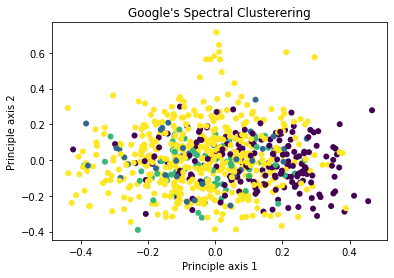

In [ ]:
from spectralcluster import SpectralClusterer

clusterer1 = SpectralClusterer(
    min_clusters=4,
    max_clusters=100,
    p_percentile=0.95,
    gaussian_blur_sigma=0.25)

labels1 = clusterer1.predict(X)
labels_test1 = clusterer1.predict(X_test)

c = np.random.choice(range(4), 100)

# plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
# plot x,y data with c as the color vector, set the line width of the markers to 0
ax.scatter(X_principal['P1'], X_principal['P2'], c=labels1, lw=0)
plt.title("Google's Spectral Clusterering")
plt.xlabel("Principle axis 1")
plt.ylabel("Principle axis 2")
plt.savefig('/content/drive/MyDrive/plots/Cluster2GSC.png')


#### Using Agglomerative Heirarchical Clustering Function

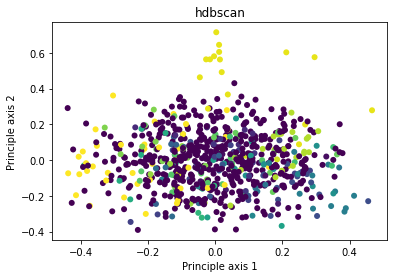

In [ ]:
import hdbscan

clusterer2 = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40,
    metric='euclidean', min_cluster_size=4, min_samples=None, p=None)

clusterer2.fit(X)
labels2 = clusterer2.labels_

clusterer2.fit(X_test)
labels_test2 = clusterer2.labels_

c = np.random.choice(range(4), 100)

# plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
# plot x,y data with c as the color vector, set the line width of the markers to 0
ax.scatter(X_principal['P1'], X_principal['P2'], c=labels2, lw=0)
plt.title("hdbscan")
plt.xlabel("Principle axis 1")
plt.ylabel("Principle axis 2")
plt.savefig('/content/drive/MyDrive/plots/Cluster5hdbscan.png')

# Make Predictions Using Embeddings


### Calculate DER values

In [ ]:
## Create Helper Fucntions to Compute DER

from pyannote.metrics.diarization import DiarizationErrorRate, GreedyDiarizationErrorRate, JaccardErrorRate

## Compute Speeker Segments from Model output
def get_hypothesis(speaker_segments):
    hypothesis = Annotation()
    for t in speaker_segments:
        try:
            hypothesis[Segment(t['start'], t['end'])] = f"{t['speaker_id']}_hyp"
        except:
            pass
        
    return hypothesis

## Compute Speeker Segments from Ground Truth
def get_ref(speaker_segments):
    reference = Annotation()
    for t in speaker_segments:
        try:
            reference[Segment(t['start'], t['end'])] = f"{t['speaker_id']}_ref"
        except:
            pass
        
    return reference

der = DiarizationErrorRate()
gder = GreedyDiarizationErrorRate()
jer = JaccardErrorRate()

## Compute DER
def measure_metrics(reference, hypothesis):
    der_value = der(reference, hypothesis)
    print('DER:', der_value)

    
    return der_value

In [ ]:
## Compute Speaker Start End Time Segments
def ref_hypo(startEndTime,startEndTime_ref,labels,y):
  speaker_segments = []
  for i in range(len(startEndTime)):
    speaker_segments.append({
                        'start': startEndTime[i][0],
                        'end': startEndTime[i][1],
                        'speaker_id': labels[i]
                    })
  speaker_segments_ref = []
  for i in range(len(startEndTime_ref)):
    speaker_segments_ref.append({
                        'start': startEndTime_ref[i][0],
                        'end': startEndTime_ref[i][1],
                        'speaker_id': y[i]
                    })
  return speaker_segments,speaker_segments_ref

labels = labels1
# labels = labels2

labels_test = labels_test1
# labels_test = labels_test2

speaker_segments,speaker_segments_ref = ref_hypo(startEndTime,startEndTime,labels,y)
speaker_segments_test,speaker_segments_ref_test = ref_hypo(startEndTime_test,startEndTime_test,labels_test,y_test)



In [ ]:
# DER for Training data

hypothesis = get_hypothesis(speaker_segments)
reference = get_ref(speaker_segments_ref)
der_value = measure_metrics(reference, hypothesis)

/usr/local/lib/python3.7/dist-packages/pyannote/metrics/utils.py:184: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  "'uem' was approximated by the union of 'reference' "


DER: 0.5190039318479686


In [ ]:
## Der for test data

hypothesis_test = get_hypothesis(speaker_segments_test)
reference_test = get_ref(speaker_segments_ref_test)
der_value = measure_metrics(reference_test, hypothesis_test)

/usr/local/lib/python3.7/dist-packages/pyannote/metrics/utils.py:184: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  "'uem' was approximated by the union of 'reference' "


DER: 0.5590327169274538


### Visualise Overall Diarization Outcome 

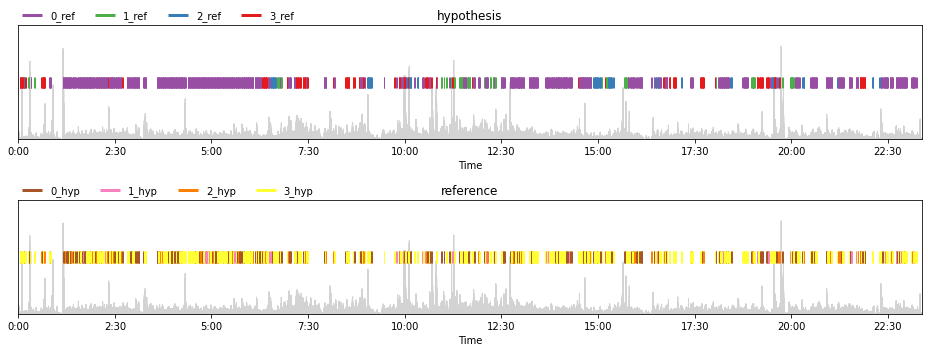

In [ ]:
import matplotlib
from matplotlib import style
import datetime
import librosa
import librosa.display

## Visualise Model Outputs as compared against the Ground Truth

def timeTicks(x, pos):
    d = datetime.timedelta(seconds=x)
    return str(d)[-5:] if x < 3600 else str(d)
formatter = matplotlib.ticker.FuncFormatter(timeTicks)

SR = 32000

def plot_der(FILEPATH,reference,hypothesis,id):
    fig = plt.figure(figsize=(13, 5))

    # plot hypothesis
    ax = plt.subplot(211)
    plt.title('hypothesis')
    ax.xaxis.set_major_formatter(formatter)
    wav, source_sr = librosa.load(FILEPATH, sr=SR)
    ticks_freq = ceil(len(wav) * .1 / source_sr)

    notebook.plot_annotation(hypothesis, legend=True, time=True)
    librosa.display.waveplot(wav, sr=source_sr, color='lightgray')

    # plot reference
    ax = plt.subplot(212)
    plt.title('reference')
    ax.xaxis.set_major_formatter(formatter)

    notebook.plot_annotation(reference, legend=True, time=True)
    librosa.display.waveplot(wav, sr=source_sr, color='lightgray')

    plt.margins(x=0.01)
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/plots/'+id +'.png')
    plt.show()

%matplotlib inline


def rh_cal(RECORDING_ID,AMI_AUDIO_FOLDER):
  X_withoutEmbedding, y, startEndTime = read_all(RECORDING_ID,AMI_AUDIO_FOLDER2)
  X_withoutEmbedding = np.resize(X_withoutEmbedding, (len(X_withoutEmbedding), 74, 35)) 
  train_dataset_embedding = tf.data.Dataset.from_tensor_slices((X_withoutEmbedding, y)) 
  train_dataset_embedding = train_dataset_embedding.batch(32)
  train_dataset_embedding = train_dataset_embedding.map(map_data)

  
  train_embeddings_t1, train_labels_tl = model.predict(train_dataset_embedding), y
  train_embeddings_t1 = np.squeeze(train_embeddings_t1,-1)                        #Comment if getting error
  train_embeddings_tl, train_labels_tl = embedder.predict(train_embeddings_t1), y #Comment if getting error
  X, y = np.array(train_embeddings_tl), np.array([int(i) for i in train_labels_tl])
  labels_spectralcluster = clusterer1.predict(X)
  speaker_segments,speaker_segments_ref = ref_hypo(startEndTime,startEndTime,labels_spectralcluster,y)
  hypothesis = get_hypothesis(speaker_segments)
  reference = get_ref(speaker_segments_ref)

  return hypothesis, reference, 


id = 'ES2009a'

ref, hypo = rh_cal(id,AMI_AUDIO_FOLDER2)
plot_der(os.path.join(os.path.join(AMI_AUDIO_FOLDER2,id,'audio'),id + '.Mix-Headset.wav'),ref,hypo,id)
